# Data Exploration

The data is downloaded from the [Open University](https://analyse.kmi.open.ac.uk/open_dataset) and contains information on students, modules, presentation and assessments. There is lots more information than is used here. This Exploration only focuses on aspects of the data used in the study.

The image below comes directly from the above website and shows the DB relation structure.

<img src=https://analyse.kmi.open.ac.uk/resources/images/model.png>

We will focus on studentAssessment results of the "Exam" type.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
datapath = 'data/'
all_results = pd.read_csv(datapath+'studentAssessment.csv')
assessments = pd.read_csv(datapath+'assessments.csv')

In [70]:
print(all_results.shape)
all_results.head()

(173912, 5)


,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [71]:
print(assessments.shape)
assessments.tail()

(206, 6)


,code_module,code_presentation,id_assessment,assessment_type,date,weight
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0
205,GGG,2014J,37444,Exam,229.0,100.0


From the website: code presentation with yyyy(J/B) are separate presentations that may differ in structure, so it may be wise to see one "course" as `code_module`+`code_presentation`. For now, though, I will just use code_module, as that is supposedly the same educational content, just given at another time, in a slightly different structure. We are interested in final grades, which are calculated as follows: the weights of all grades for assessments (other than Exam) add up to 100%, and the Exam has weight 100% as well. The website says nothing about how the grade of a course is calculated, so we will assume it is the average of exam and assessments, if both exist.

In [72]:
# assessments['course'] = assessments.code_module + assessments.code_presentation
assessments['course'] = assessments.code_module
exams = assessments[assessments.assessment_type == "Exam"]
assessments = assessments[assessments.assessment_type != "Exam"]
print(f'That leaves us with {assessments.shape[0]} assessments and {exams.shape[0]} exams')

That leaves us with 182 assessments and 24 exams


In [73]:
exams

,code_module,code_presentation,id_assessment,assessment_type,date,weight,course
5,AAA,2013J,1757,Exam,NaN,100.0,AAA
11,AAA,2014J,1763,Exam,NaN,100.0,AAA
23,BBB,2013B,14990,Exam,NaN,100.0,BBB
35,BBB,2013J,15002,Exam,NaN,100.0,BBB
47,BBB,2014B,15014,Exam,NaN,100.0,BBB
53,BBB,2014J,15025,Exam,NaN,100.0,BBB
62,CCC,2014B,24290,Exam,NaN,100.0,CCC
63,CCC,2014B,40087,Exam,NaN,100.0,CCC
72,CCC,2014J,24299,Exam,NaN,100.0,CCC
73,CCC,2014J,40088,Exam,NaN,100.0,CCC


In [74]:
results = all_results.merge(exams, how='inner', on='id_assessment')#[['id_student', 'course', 'score', 'assessment_type']]
results_assessments = all_results.merge(assessments, how='inner', on='id_assessment')

In [75]:
print(results.shape)
# print(f'{len(np.unique(results.id_student))} unique students following {len(np.unique(results.course))} courses.')
results.head()

(4959, 11)


,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,course
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,CCC
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,CCC
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,CCC
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,CCC
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,CCC


So, added up, per student, per code_module, the weights should be one hundred for all non-exams. Apparently, not everyone handed in everything.

In [76]:
results_assessments["frac_score"] = results_assessments.weight * results_assessments.score

pcps_weightedscore = results_assessments.groupby(['code_module', 'id_student']).frac_score.sum() / results_assessments.groupby(['code_module', 'id_student']).weight.sum()

pcps = pd.DataFrame(pcps_weightedscore).reset_index().rename(columns={0:'score'})
pcps.head()

,code_module,id_student,score
0,AAA,6516,63.5
1,AAA,11391,82.4
2,AAA,24734,47.5
3,AAA,26192,86.3
4,AAA,28061,77.4


### There are only exams of students for coursed CCC and DDD, while IDs exist for all...

Instead, let's go for exams for a course and assessments for a course as separate course results!

In [77]:
pcps['code_module'] = pcps.code_module + '_a'
student_results = pd.concat([results[['code_module', 'id_student', 'score']], pcps], axis=0).dropna()

In [78]:
student_results

,code_module,id_student,score
0,CCC,558914,32.00
1,CCC,559706,78.00
2,CCC,559770,54.00
3,CCC,560114,64.00
4,CCC,560311,100.00
...,...,...,...
22972,FFF_a,2694680,86.50
22973,FFF_a,2697630,66.50
22974,FFF_a,2697885,77.50
22975,FFF_a,2697921,80.25


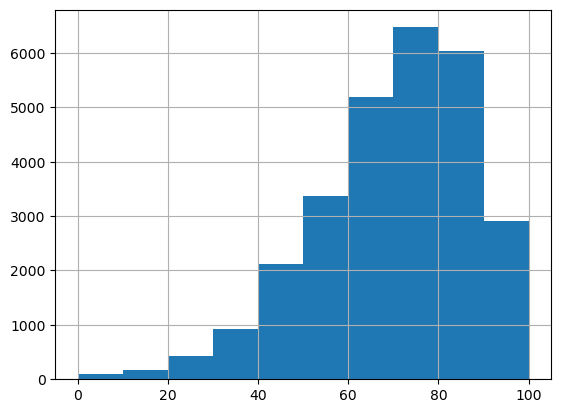

In [79]:
student_results.score.hist();

Let's see if a network can be built out of this. Useless data, almost all students are unique, no overlapping groups.